In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class SimpleUNet(nn.Module):
    """
    A simplified U-Net model for diffusion
    """
    def __init__(self, in_channels=1, time_embedding_dim=256):
        super().__init__()
        
        self.time_embedding = nn.Sequential(
            nn.Linear(1, time_embedding_dim),
            nn.SiLU(),
            nn.Linear(time_embedding_dim, time_embedding_dim),
        )
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        
        # Decoder
        self.conv4 = nn.Conv2d(256 + time_embedding_dim, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, in_channels, 3, padding=1)
        
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embedding(t.unsqueeze(-1).float())
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)
        t_emb = t_emb.expand(-1, -1, x.shape[2], x.shape[3])
        
        # Encoder
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))
        
        # Add time embedding
        x3 = torch.cat([x3, t_emb], dim=1)
        
        # Decoder
        x = F.relu(self.conv4(x3))
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
        
        return x

Using device: cuda


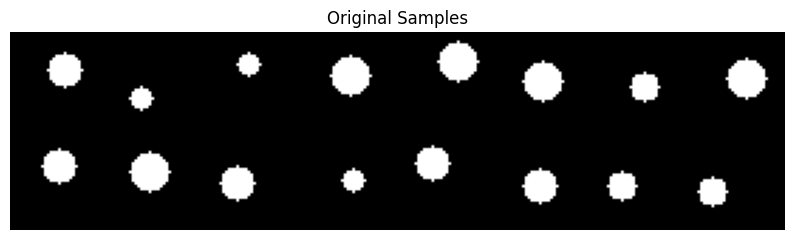

Epoch 100/1000: 100%|██████████| 16/16 [00:00<00:00, 38.15it/s]


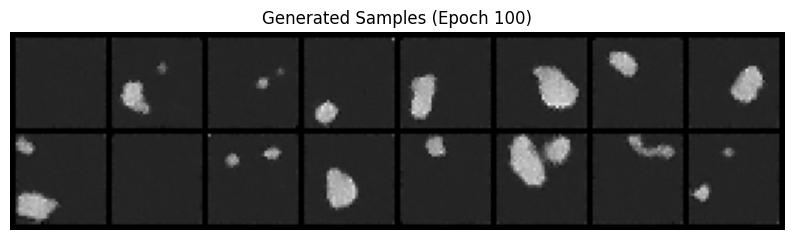

Epoch 200/1000: 100%|██████████| 16/16 [00:00<00:00, 35.33it/s]


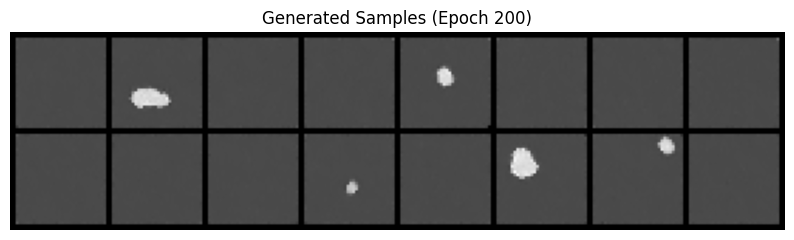

Epoch 300/1000: 100%|██████████| 16/16 [00:00<00:00, 36.79it/s]


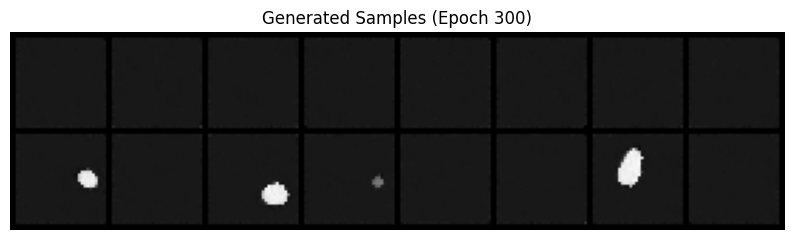

Epoch 400/1000: 100%|██████████| 16/16 [00:00<00:00, 36.30it/s]


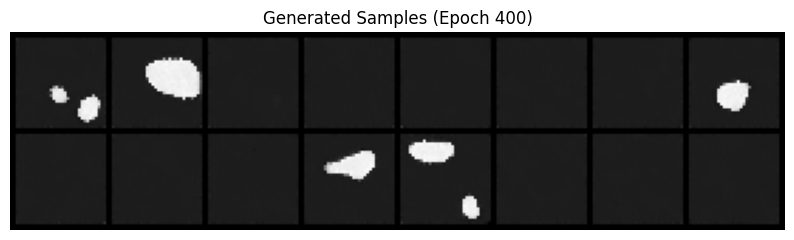

Epoch 500/1000: 100%|██████████| 16/16 [00:00<00:00, 36.58it/s]


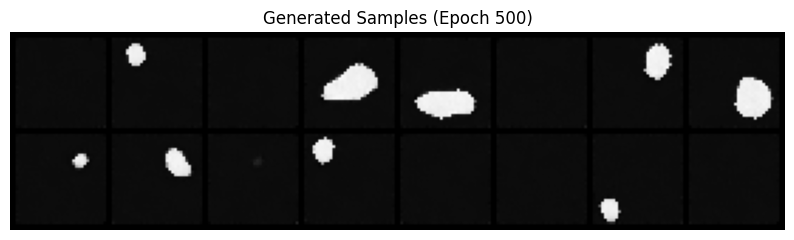

Epoch 600/1000: 100%|██████████| 16/16 [00:00<00:00, 37.85it/s]


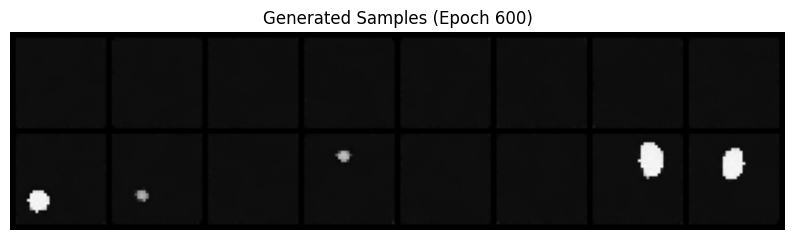

Epoch 700/1000: 100%|██████████| 16/16 [00:00<00:00, 36.84it/s]


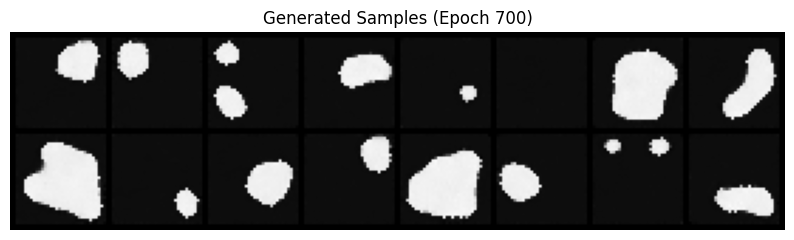

Epoch 800/1000: 100%|██████████| 16/16 [00:00<00:00, 28.67it/s]


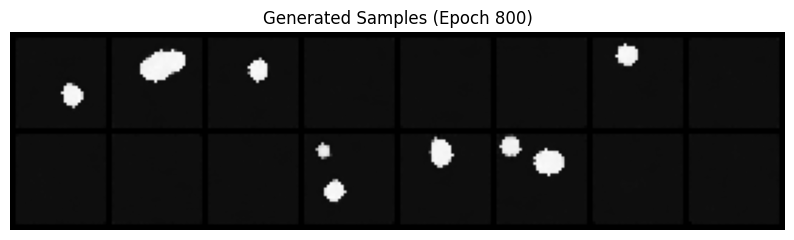

Epoch 900/1000: 100%|██████████| 16/16 [00:00<00:00, 29.03it/s]


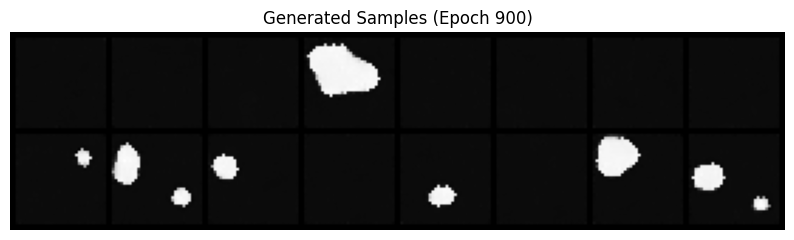

Epoch 1000/1000: 100%|██████████| 16/16 [00:00<00:00, 28.72it/s]


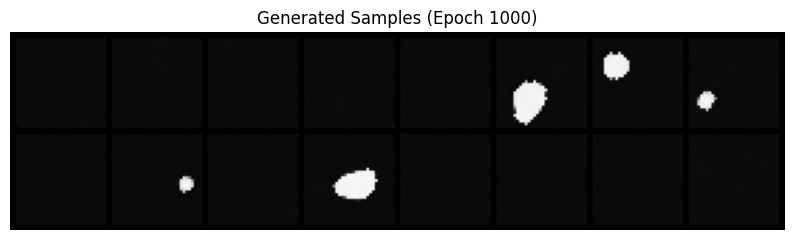

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm

class SimpleDiffusionModel:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        """
        Initialize diffusion model parameters.
        
        Args:
            num_timesteps: Number of noise steps
            beta_start: Starting value for noise schedule
            beta_end: Ending value for noise schedule
            device: Device to put the model on
        """
        self.num_timesteps = num_timesteps
        self.device = device
        
        # Define noise schedule and move to correct device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

    def forward_diffusion(self, x_0, t):
        """
        Forward diffusion process: q(x_t | x_0)
        Args:
            x_0: Initial data
            t: Timestep
        Returns:
            Noisy sample x_t and noise
        """
        noise = torch.randn_like(x_0, device=self.device)
        
        # Ensure t is on the correct device
        t = t.to(self.device)
        
        # Extract coefficients for this timestep
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        
        # Apply forward diffusion equation
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def reverse_diffusion_sample(self, model, shape, device, noise=None):
        """
        Sampling from the reverse diffusion process
        
        Args:
            model: Neural network model
            shape: Shape of desired sample
            device: Device to run on
            noise: Optional starting noise
        Returns:
            Generated sample
        """
        if noise is None:
            noise = torch.randn(shape, device=device)
        
        x_t = noise
        
        # Iterate through timesteps backwards
        for t in range(self.num_timesteps - 1, -1, -1):
            t_tensor = torch.full((shape[0],), t, device=device, dtype=torch.long)
            
            # If last step, don't add noise
            if t == 0:
                noise = 0
            else:
                noise = torch.randn_like(x_t)
            
            # Get model prediction
            predicted_noise = model(x_t, t_tensor)
            
            # Calculate coefficients
            alpha_t = self.alphas[t]
            alpha_t_cumprod = self.alphas_cumprod[t]
            beta_t = self.betas[t]
            
            # Apply reverse diffusion equation
            x_t = (1 / torch.sqrt(alpha_t)) * (
                x_t - (beta_t / torch.sqrt(1 - alpha_t_cumprod)) * predicted_noise
            ) + torch.sqrt(beta_t) * noise
            
        return x_t

def create_circle_dataset(num_samples=1000, image_size=32, device='cuda'):
    """Generate a dataset of circles with random positions"""
    dataset = []
    for _ in range(num_samples):
        image = np.zeros((image_size, image_size))
        
        center_x = np.random.randint(image_size // 4, 3 * image_size // 4)
        center_y = np.random.randint(image_size // 4, 3 * image_size // 4)
        radius = np.random.randint(image_size // 8, image_size // 4)
        
        y, x = np.ogrid[:image_size, :image_size]
        dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        
        image[dist_from_center <= radius] = 1.0
        dataset.append(image)
    
    # Convert to torch tensor and move to device
    dataset = torch.FloatTensor(dataset).unsqueeze(1).to(device)  # Add channel dimension
    return dataset

def diffusion_loss(model, x_0, diffusion):
    """Calculate the diffusion loss for training"""
    batch_size = x_0.shape[0]
    
    # Sample random timesteps
    t = torch.randint(0, diffusion.num_timesteps, (batch_size,), device=diffusion.device)
    
    # Get noisy image and original noise
    x_t, noise = diffusion.forward_diffusion(x_0, t)
    
    # Get model's noise prediction
    predicted_noise = model(x_t, t)
    
    # Calculate simple MSE loss between actual and predicted noise
    loss = F.mse_loss(predicted_noise, noise)
    
    return loss

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create dataset
dataset = create_circle_dataset(num_samples=1000, device=device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize models and optimizer
diffusion = SimpleDiffusionModel(num_timesteps=500, device=device)
model = SimpleUNet(in_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 1000
save_interval = 100

def plot_samples(samples, title):
    """Utility function to plot a grid of images"""
    # Move samples to CPU for plotting
    samples = samples.cpu()
    grid = make_grid(samples, nrow=8, normalize=True, padding=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show some original samples
plot_samples(dataset[:16], "Original Samples")

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        loss = diffusion_loss(model, batch, diffusion)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    # print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
    
    # Generate and visualize samples periodically
    if (epoch + 1) % save_interval == 0:
        model.eval()
        with torch.no_grad():
            samples = diffusion.reverse_diffusion_sample(
                model,
                shape=(16, 1, 32, 32),
                device=device
            )
            plot_samples(samples, f"Generated Samples (Epoch {epoch+1})")